# Speed visualization on track map

(Example provided by @JSEHV on Github)


In [35]:
import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import pandas as pd
from scipy.interpolate import splprep, splev


import fastf1 as ff1

First, we define some variables that allow us to conveniently control what
we want to plot.



In [36]:
year = 2024
wknd = 5
ses = 'R'
driver = 'HAM'
colormap = mpl.cm.plasma

Next, we load the session and select the desired data.



In [37]:
session = ff1.get_session(year, wknd, ses)
weekend = session.event
session.load()
lap = session.laps.pick_drivers(driver).pick_fastest()
tel = lap.get_telemetry()
circuit_info = session.get_circuit_info()
corners = circuit_info.corners
print(corners)
dists = corners['Distance'].values

# Get telemetry data
x = lap.telemetry['X']              # values for x-axis
y = lap.telemetry['Y']              # values for y-axis
color = lap.telemetry['Speed']      # value to base color gradient on

core           INFO 	Loading data for Chinese Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:08.313000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '11', '16', '55', '63', '14', '81', '44', '27', '31', '23

              X            Y  Number Letter       Angle     Distance
0  -5247.443359 -2414.479736       1        -122.954301   571.067594
1  -5133.338867  -986.181580       2         -83.202363   736.949073
2  -4563.621582 -2055.360596       3          73.790086   878.530221
3  -4096.869141 -1006.836670       4          21.782232  1009.149628
4  -6014.227051  1311.962524       5        -150.575836  1303.090656
5  -6594.757812  3667.179443       6         103.617312  1557.579815
6  -3495.405273   611.896423       7          94.161503  2031.086283
7  -1413.267456  2477.544678       8         -90.461792  2311.577293
8   -166.506866  1202.739990       9          72.105469  2498.067086
9    600.005554  1968.239136      10          -5.989765  2611.960606
10 -1811.592285  6056.277832      11          75.793997  3072.642177
11 -2493.604248  5631.430664      12         -94.047260  3150.344979
12 -2345.069824  7168.982422      13         104.391458  3345.611916
13  5434.506348 -3601.620361      

In [38]:
turns = [1, 2, 3, 4]
turn = corners[corners['Number'].isin(turns)]


# indici nel vettore dists
idx_first = corners[corners['Number']==turn.loc[0,'Number']].index[0]
idx_last  = corners[corners['Number']==turn.loc[len(turn)-1,'Number']].index[0]

d_prev = dists[idx_first-1] if idx_first>0 else 0
d0     = dists[idx_first]
d_end0 = dists[idx_last]
d_next = dists[idx_last+1] if idx_last < len(dists)-1 else tel['Distance'].max()

d_start = (d_prev + d0)     / 2
d_end   = (d_end0 + d_next) / 2

turn_tel = tel.loc[(tel['Distance'] >= d_start) & (tel['Distance'] <= d_end)]


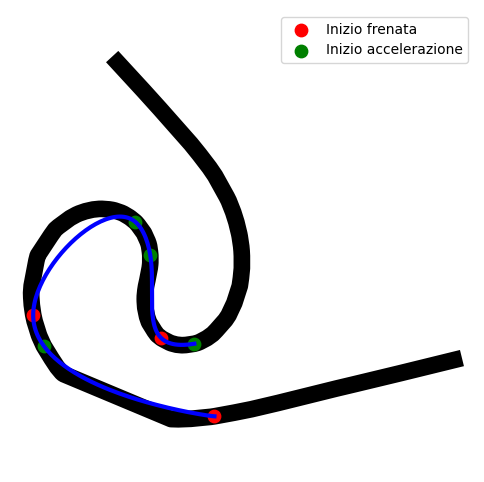

In [39]:
brk = turn_tel['Brake'].astype(int)
mask_brake_start = brk.diff() == 1
brake_pts = turn_tel.loc[mask_brake_start, ['Distance','X','Y']]

# Throttle ≤5%→>5%
thr = turn_tel['Throttle']
mask_accel_start = (thr > 5) & (thr.shift(1) <= 5)
accel_pts = turn_tel.loc[mask_accel_start, ['Distance','X','Y']]

traj = pd.concat([brake_pts, accel_pts], ignore_index=True)
traj = traj.sort_values(by='Distance')

tck, u = splprep([traj['X'].values, traj['Y'].values], s=0)
u_fine = np.linspace(0, 1, 200)
x_smooth, y_smooth = splev(u_fine, tck)

fig, ax = plt.subplots(figsize=(6,6))

# (A) tracciato di base con il giro più veloce
ax.plot(turn_tel['X'], turn_tel['Y'], color='black', linewidth=12, zorder=0)
ax.plot(x_smooth, y_smooth, color='blue', linewidth=3, zorder=2)

# (B) scatter dei punti per la curva selezionata
ax.scatter(brake_pts['X'],  brake_pts['Y'],
           c='red',   s=80, label='Inizio frenata',    zorder=1)
ax.scatter(accel_pts['X'], accel_pts['Y'],
           c='green', s=80, label='Inizio accelerazione', zorder=1)

ax.axis('equal')
ax.axis('off')
ax.legend(loc='upper right', frameon=True)

plt.show()

Now, we create a set of line segments so that we can color them
individually. This creates the points as a N x 1 x 2 array so that we can
stack points  together easily to get the segments. The segments array for
line collection needs to be (numlines) x (points per line) x 2 (for x and y)



In [ ]:
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

After this, we can actually plot the data.



In [1]:
# We create a plot with title and adjust some setting to make it look good.
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(12, 6.75))
fig.suptitle(f'{weekend.name} {year} - {driver} - Speed', size=24, y=0.97)

# Adjust margins and turn of axis
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.12)
ax.axis('off')


# After this, we plot the data itself.
# Create background track line
ax.plot(lap.telemetry['X'], lap.telemetry['Y'],
        color='black', linestyle='-', linewidth=16, zorder=0)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(color.min(), color.max())
lc = LineCollection(segments, cmap=colormap, norm=norm,
                    linestyle='-', linewidth=5)

# Set the values used for colormapping
lc.set_array(color)

# Merge all line segments together
line = ax.add_collection(lc)


# Finally, we create a color bar as a legend.
cbaxes = fig.add_axes([0.25, 0.05, 0.5, 0.05])
normlegend = mpl.colors.Normalize(vmin=color.min(), vmax=color.max())
legend = mpl.colorbar.ColorbarBase(cbaxes, norm=normlegend, cmap=colormap,
                                   orientation="horizontal")


# Show the plot
plt.show()

NameError: name 'plt' is not defined